# Natural Language Processing

## Dependency Parsing Homework



**Assignment:**

1. Read https://aclanthology.org/D14-1082.pdf and maybe just write one paragraph summary in your README.md in your github

2. Do something called ablation study (meaning try to delete something so we know the impact of that deleted thing - very common in NLP)
Recall that we have 18 word + 18 pos + 12 dep features
Try to delete only the 12 dep features and check UAS
Try to delete only the 18 pos features and check UAS
3. Do another comparison study testing the embedding
Chaky uses some embedding
Try to use (1) glove embedding (smallest), (2) nn.Embedding (train from scratch) and compare with Chaky's embedding - on how it affects the UAS
4. Do some testing, compare 2-3 sentences with spaCy and see whether our neural network gives the same dependency.

In [1]:
#importing libraries
import sys
import numpy as np
import time
import os
import logging
from collections import Counter
from datetime import datetime
import math

from tqdm import tqdm  
import pickle 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim

## 1. Parsing function


Let's make a class `Parsing`, representing a parser for each sentence.  For each sentence, we need the `stack`, `buffer`, and the `dependencies`.

In [2]:
class Parsing(object):
    def __init__(self, sentence):
        self.sentence = sentence #['The', 'cat', 'sat']
        
        # The current stack represented as a list with the top of the stack as the
        # last element of the list.
        self.stack = ['ROOT']
        
        # The current buffer represented as a list with the first item on the
        # buffer as the first item of the list
        self.buffer = sentence[:]
        
        # The list of dependencies produced so far. Represented as a list of
        # tuples where each tuple is of the form (head, dependent).
        self.dep = []
    
    #Let's first create a function to perform "Shift", "Left-Arc", and "Right-Arc"
    def parse_step(self, transition):
        if transition == 'S':
            buffer_head = self.buffer.pop(0)
            self.stack.append(buffer_head)
        #stack: [ROOT, I, parsed]
        elif transition == 'LA':
            dependent = self.stack.pop(-2) #I
            self.dep.append((self.stack[-1], dependent)) #(parsed, I)
        #stack: [ROOT, parsed, sentence]
        elif transition == 'RA':
            dependent = self.stack.pop() #sentence
            self.dep.append((self.stack[-1], dependent)) #(parsed, sentence)
        else:
            print(f"Unknown transition: {transition}")
            
    #loop all transitions
    def parse(self, transitions):
        for transition in transitions:
            self.parse_step(transition)
        return self.dep
    
    #an utility function to check that the parsing is done.
    def is_completed(self):
        return (len(self.buffer) == 0) and (len(self.stack) == 1)

### Testing the parse step

In [3]:
parsing = Parsing(["The", "cat", "sat"])
parsing.parse(["S", "LA", "S", "RA"])
parsing.stack, parsing.buffer, parsing.dep

(['The'], ['sat'], [('The', 'ROOT'), ('The', 'cat')])

### Minibatch parsing

Let's create a minibatch loader that loads a bunch of sentences, and perform parse accordingly.  For now, we will assume a very dump model to predict the transitions.

In [4]:
def minibatch_parse(sentences, model, batch_size):
    dep = []

    # Initialize a list of DepParser, one for each sentence.
    partial_parses = [Parsing(sentence) for sentence in sentences]
    
    # Shallow copy partial_parses.
    unfinished_parses = partial_parses[:]
        
    # While unfinished_parses is not empty do.
    while unfinished_parses:
        # Take first batch_size parses in unfinished_parses as minibatch.
        minibatch = unfinished_parses[:batch_size]
        # Use model to predict next transition for each partial parse in the minibatch.
        transitions = model.predict(minibatch)
        # Perform parse step for each partial_parse_minibatch with their predicted transition.
        for transition, partial_parse in zip(transitions, minibatch):
            partial_parse.parse_step(transition)
        # Remove completed parses.
        unfinished_parses[:] = [
            p for p in unfinished_parses if not p.is_completed()]
    dep = [parse.dep for parse in partial_parses]

    return dep

In [5]:
class DummyModel(object):
    """
    Dummy model for testing the minibatch_parse function
    First shifts everything onto the stack and then does exclusively right arcs if the first word of
    the sentence is "right", "left" if otherwise.
    """

    def predict(self, partial_parses):
        return [("RA" if pp.stack[1] == "right" else "LA") if len(pp.buffer) == 0 else "S"
                for pp in partial_parses]

In [6]:
sentences = [["right", "arcs", "only"],
             ["right", "arcs", "only", "again"],
             ["left", "arcs", "only"],
             ["left", "arcs", "only", "again"]]
deps = minibatch_parse(sentences, DummyModel(), 2)

## 2. Load data


We used English Penn Treebank dataset in CoNLL format.

CoNLL is the conventional name for TSV formats in NLP (TSV - tab-separated values, i.e., CSV with <TAB> as separator).
It originates from a series of shared tasks organized at the Conferences of Natural Language Learning (hence the name)

In CoNLL formats,
- every word (token) is represented in one line
- every sentence is separated from the next by an empty line
- every column represents one annotation

There are many formats, in our case, our conll file has 10 columns, the important columns are:
- 1:  word
- 4:  pos
- 6:  head of the dependency
- 7:  type of dependency

In [7]:
#function for reading the conll file
def read_conll(filename, max_example=5):
    examples = []
    with open(filename) as f:
        i = 0
        word, pos, head, dep = [], [], [], []
        for line in f.readlines():
            i = i + 1
            wa = line.strip().split('\t') #wa = word annotations
            
            #if all 10 columns are there....
            if len(wa) == 10:  
                word.append(wa[1].lower())
                pos.append(wa[4])
                head.append(int(wa[6]))
                dep.append(wa[7])
            
            #otherwise, it means the line is empty, thus we consider finish for one example
            elif len(word) > 0:
                examples.append({'word': word, 'pos': pos, 'head': head, 'dep': dep})
                word, pos, head, dep = [], [], [], []
                    
        #last example
        if len(word) > 0:
            examples.append({'word': word, 'pos': pos, 'head': head, 'dep': dep})
            
    return examples

### Testing the load function

In [8]:
def load_data():
    print("1. Loading data")
    train_set = read_conll("train.conll")
    dev_set = read_conll("dev.conll")
    test_set = read_conll("test.conll")
    
    return train_set[:1000], dev_set[:500], test_set[:500]

In [9]:
train_set, dev_set, test_set = load_data()

1. Loading data


In [10]:
#checking the size of datasets
len(train_set), len(dev_set), len(test_set)

(1000, 500, 500)

## 3. Parser

We will create a parser that will help us:
- create a `tok2id` dictionary in the `__init__` function
- numercalize `numercalize` the words, dependencies, and pos tags
- create training data, `create_instances` by leveraging the ground truth of the dependencies
- finally the `parse` function

This feature vector consists of a list of tokens. They can be represented as a list of integers $\mathbf{w} = [w_1, w_2, \cdots, w_m]$ where $m$ is the number of features and each $0 \leq w_i \leq |V|$ is the index of a token in the vocabulary ($|V|$ is the vocabulary size).  Then our network looks up an embedding for each word and concatenates them into a single input vector:

$$\mathbf{x} = [\mathbf{E}_{w_1}, \cdots, \mathbf{E}_{w_m}] \in \mathbb{R}^{dm}$$

where $\mathbf{E} \in \mathbb{R}^{|V| \times d}$ is an embedding matrix with each row $\mathbf{E}_w$ as the vector for a particular word $w$

In [11]:
P_PREFIX = '<p>:' #indicating pos tags
D_PREFIX = '<d>:' #indicating dependency tags
UNK      = '<UNK>'
NULL     = '<NULL>'
ROOT     = '<ROOT>'

class Parser(object):

    def __init__(self, dataset):
        
        #set the root dep
        self.root_dep = 'root'
                
        #get all the dep of the dataset as list, e.g., ['root', 'acl', 'nmod', 'nmod:npmod']
        all_dep = [self.root_dep] + list(set([w for ex in dataset
                                               for w in ex['dep']
                                               if w != self.root_dep]))
        
        #1. put dep into tok2id lookup table, with D_PREFIX so we know it is dependency
        #{'D_PREFIX:root': 0, 'D_PREFIX:acl': 1, 'D_PREFIX:nmod': 2, ..., 'D_PREFIX:<NULL>': 30}
        tok2id = {D_PREFIX + l: i for (i, l) in enumerate(all_dep)}
        tok2id[D_PREFIX + NULL] = self.D_NULL = len(tok2id)
        
        #we are using "unlabeled" where we do not label with the dependency
        #thus the number of dependency relation is 1
        trans = ['L', 'R', 'S']
        self.n_deprel = 1
        
        #create a simple lookup table mapping action and id
        #e.g., tran2id: {'L': 0, 'R': 1, 'S': 2}
        #e.g., id2tran: {0: 'L', 1: 'R', 2: 'S'}
        self.n_trans = len(trans)
        self.tran2id = {t: i for (i, t) in enumerate(trans)}
        self.id2tran = {i: t for (i, t) in enumerate(trans)}

        #2. put pos tags into tok2id lookup table, with P_PREFIX so we know it is pos
        tok2id.update(build_dict([P_PREFIX + w for ex in dataset for w in ex['pos']],
                                  offset=len(tok2id)))
        tok2id[P_PREFIX + UNK]  = self.P_UNK  = len(tok2id)  #also remember the pos tags of unknown
        tok2id[P_PREFIX + NULL] = self.P_NULL = len(tok2id)
        tok2id[P_PREFIX + ROOT] = self.P_ROOT = len(tok2id)
        
        #now tok2id:  {'P_PREFIX:root': 0, 'P_PREFIX:acl': 1, ..., 'P_PREFIX:JJR': 62, 'P_PREFIX:<UNK>': 63, 'P_PREFIX:<NULL>': 64, 'P_PREFIX:<ROOT>': 65}
        
        #3. put word into tok2id lookup table
        tok2id.update(build_dict([w for ex in dataset for w in ex['word']],
                                  offset=len(tok2id)))
        tok2id[UNK]  = self.UNK = len(tok2id)
        tok2id[NULL] = self.NULL = len(tok2id)
        tok2id[ROOT] = self.ROOT = len(tok2id)
        
        #now tok2id: {'D_PREFIX:root': 0, 'D_PREFIX:acl': 1, 'D_PREFIX:nmod': 2, ..., 'memory': 340, 'mr.': 341, '<UNK>': 342, '<NULL>': 343, '<ROOT>': 344}
        
        #create id2tok
        self.tok2id = tok2id
        self.id2tok = {v: k for (k, v) in tok2id.items()}
        
        #why 18 normal features + 18 (pos) + 12 (dep)
        #18 features - top 3 words on buffer, top 3 words on stack, 
        # the first and second left most/rightmost children of the top two words on the stack
        # the leftmost of leftmost/rightmost of rightmost children of the top two words on the stack
        #18 pos - basically corresponding POS tags
        #12 dep - corresponding ARC, excluding 6 words on hte stack/buffer..
        self.n_features = 18 + 18 + 12
        self.n_tokens = len(tok2id)
    
    #function to turn train set with words to train set with id instead using tok2id
    def numericalize(self, examples):
        numer_examples = []
        for ex in examples:
            word = [self.ROOT] + [self.tok2id[w] if w in self.tok2id
                                  else self.UNK for w in ex['word']]
            pos  = [self.P_ROOT] + [self.tok2id[P_PREFIX + w] if P_PREFIX + w in self.tok2id
                                   else self.P_UNK for w in ex['pos']]
            head = [-1] + ex['head']
            dep  = [-1] + [self.tok2id[D_PREFIX + w] if D_PREFIX + w in self.tok2id
                            else -1 for w in ex['dep']]
            numer_examples.append({'word': word, 'pos': pos,
                                 'head': head, 'dep': dep})
        return numer_examples

    #function to extract features to form a feature embedding matrix
    def extract_features(self, stack, buf, arcs, ex):
             
        #ex['word']:  [55, 32, 33, 34, 35, 30], i.e., ['root', 'ms.', 'haag', 'plays', 'elianti', '.']
        #ex['pos']:   [29, 14, 14, 16, 14, 17], i.e., ['NNP', 'NNP', 'VBZ', 'NNP', '.']
        #ex['head']:  [-1, 2, 3, 0, 3, 3]  or ['root', 'compound', 'nsubj', 'root', 'dobj', 'punct']}
        #ex['dep']:   [-1, 1, 2, 0, 6, 12] or ['compound', 'nsubj', 'root', 'dobj', 'punct']

        #stack     :  [0]
        #buffer    :  [1, 2, 3, 4, 5]
        
        if stack[0] == "ROOT":
            stack[0] = 0  #start the stack with [ROOT]

        #get leftmost children based on the dependency arcs
        def get_lc(k):
            return sorted([arc[1] for arc in arcs if arc[0] == k and arc[1] < k])

        #get right most children based on the dependency arcs
        def get_rc(k):
            return sorted([arc[1] for arc in arcs if arc[0] == k and arc[1] > k],
                          reverse=True)

        p_features = [] #pos features (2a, 2b, 2c) - 18
        d_features = [] #dep features (3b, 3c) - 12
        
        #last 3 things on the stack as features
        #if the stack is less than 3, then we simply append NULL from the left
        features = [self.NULL] * (3 - len(stack)) + [ex['word'][x] for x in stack[-3:]]
        
        # next 3 things on the buffer as features
        #if the buffer is less than 3, simply append NULL
        #the reason why NULL is appended on end because buffer is read left to right
        features += [ex['word'][x] for x in buf[:3]] + [self.NULL] * (3 - len(buf))
        
        #corresponding pos tags
        p_features = [self.P_NULL] * (3 - len(stack)) + [ex['pos'][x] for x in stack[-3:]]
        p_features += [ex['pos'][x] for x in buf[:3]] + [self.P_NULL] * (3 - len(buf))
        
        #get the leftmost and rightmost children of the top two words, thus we loop 2 times
        for i in range(2):
            if i < len(stack):
                k = stack[-i-1] #-1, -2 last two in the stack
                
                #the first and second lefmost/rightmost children of the top two words (i=1, 2) on the stack
                lc = get_lc(k)  
                rc = get_rc(k)
                
                #the leftmost of leftmost/rightmost of rightmost children of the top two words on the stack:
                llc = get_lc(lc[0]) if len(lc) > 0 else []
                rrc = get_rc(rc[0]) if len(rc) > 0 else []

                #(leftmost of first word on stack, rightmost of first word, 
                # leftmost of the second word on stack, rightmost of second, 
                # leftmost of leftmost, rightmost of rightmost
                features.append(ex['word'][lc[0]] if len(lc) > 0 else self.NULL)
                features.append(ex['word'][rc[0]] if len(rc) > 0 else self.NULL)
                features.append(ex['word'][lc[1]] if len(lc) > 1 else self.NULL)
                features.append(ex['word'][rc[1]] if len(rc) > 1 else self.NULL)
                features.append(ex['word'][llc[0]] if len(llc) > 0 else self.NULL)
                features.append(ex['word'][rrc[0]] if len(rrc) > 0 else self.NULL)

                #corresponding pos
                p_features.append(ex['pos'][lc[0]] if len(lc) > 0 else self.P_NULL)
                p_features.append(ex['pos'][rc[0]] if len(rc) > 0 else self.P_NULL)
                p_features.append(ex['pos'][lc[1]] if len(lc) > 1 else self.P_NULL)
                p_features.append(ex['pos'][rc[1]] if len(rc) > 1 else self.P_NULL)
                p_features.append(ex['pos'][llc[0]] if len(llc) > 0 else self.P_NULL)
                p_features.append(ex['pos'][rrc[0]] if len(rrc) > 0 else self.P_NULL)
            
                #corresponding dep
                d_features.append(ex['dep'][lc[0]] if len(lc) > 0 else self.D_NULL)
                d_features.append(ex['dep'][rc[0]] if len(rc) > 0 else self.D_NULL)
                d_features.append(ex['dep'][lc[1]] if len(lc) > 1 else self.D_NULL)
                d_features.append(ex['dep'][rc[1]] if len(rc) > 1 else self.D_NULL)
                d_features.append(ex['dep'][llc[0]] if len(llc) > 0 else self.D_NULL)
                d_features.append(ex['dep'][rrc[0]] if len(rrc) > 0 else self.D_NULL)
                
            else:
                #attach NULL when they don't exist
                features += [self.NULL] * 6
                p_features += [self.P_NULL] * 6
                d_features += [self.D_NULL] * 6

        features += p_features + d_features
        assert len(features) == self.n_features  #assert they are 18 + 18 + 12
        return features

    #decide whether to shift, leftarc, or rightarc, based on gold parse trees
    #this is needed to create training examples which contain samples and ground truth
    def get_oracle(self, stack, buf, ex):

        #leave if the stack is only 1, thus nothing to predict....
        if len(stack) < 2:
            return self.n_trans - 1

        #predict based on the last two words on the stack
        i0 = stack[-1]
        i1 = stack[-2]

        #get the head and dependency
        h0 = ex['head'][i0]
        h1 = ex['head'][i1]
        d0 = ex['dep'][i0]
        d1 = ex['dep'][i1]

        #either shift, left arc or right arc
        #"Shift" = 2; "LA" = 0; "RA" = 1
        #if head of the second last word is the last word, then leftarc
        if (i1 > 0) and (h1 == i0):
            return 0
        #if head of the last word is the second last word, then rightarc
        #make sure nothing in the buffer has head with the last word on the stack
        #otherwise, we lose the last word.....
        elif (i1 >= 0) and (h0 == i1) and \
                (not any([x for x in buf if ex['head'][x] == i0])):
            return 1
        #otherwise shift, if something is left in buffer, otherwise, do nothing....
        else:
            return None if len(buf) == 0 else 2

    #generate training examples
    #from the training sentences and their gold parse trees 
    def create_instances(self, examples):
        all_instances = []
        
        for i, ex in enumerate(examples):
            #e.g., ex['word]: [344, 163, 99, 164, 165, 68]
            n_words = len(ex['word']) - 1  #excluding the root

            #arcs = {(head, tail, dependency label)}
            stack = [0]
            buf = [i + 1 for i in range(n_words)]  #[1, 2, 3, 4, 5]
            arcs = []
            instances = []
            
            #because that's the maximum number of shift, leftarcs, rightarcs you can have
            #this will determine the sample size of each training example
            #if given five words, we will get a sample of (10, 48) where 10 comes from 5 * 2, and 48 is n_features
            #but this for loop can be break if there is nothing left....
            for i in range(n_words * 2):

                #get the gold transition based on the parse trees
                #gold_t can be either shift(2), leftarc(0), or rightarc(1)
                gold_t = self.get_oracle(stack, buf, ex)
                
                #if gold_t is None, no need to extract features.....
                if gold_t is None:
                    break
                
                #make sure when the model predicts, we inform the current state of stack and buffer, so
                #the model is not allowed to make any illegal action, e.g., buffer is empty but trying to pop
                legal_labels = self.legal_labels(stack, buf)                
                assert legal_labels[gold_t] == 1
               
                #extract all the 48 features 
                features = self.extract_features(stack, buf, arcs, ex)
                instances.append((features, legal_labels, gold_t))
            
                #shift 
                if gold_t == 2:
                    stack.append(buf[0])
                    buf = buf[1:]
                #left arc 
                elif gold_t == 0:
                    arcs.append((stack[-1], stack[-2], gold_t))
                    stack = stack[:-2] + [stack[-1]]
                #right arc
                else:
                    arcs.append((stack[-2], stack[-1], gold_t - self.n_deprel))
                    stack = stack[:-1]
            else:
                all_instances += instances

        return all_instances

    #provide an one hot encoding of the labels
    def legal_labels(self, stack, buf):
        labels =  ([1] if len(stack) > 2  else [0]) * self.n_deprel   #left arc   But cannot ROOT <----He thus 3
        labels += ([1] if len(stack) >= 2 else [0]) * self.n_deprel   #right arc  ROOT--->He
        labels += [1] if len(buf) > 0 else [0]   #shift
        return labels
    
    #a simple function to check punctuation POS tags
    def punct(self, pos):
        return pos in ["''", ",", ".", ":", "``", "-LRB-", "-RRB-"]

    def parse(self, dataset, eval_batch_size=5000):
        sentences = []
        sentence_id_to_idx = {}
                
        for i, example in enumerate(dataset):
            
            #example['word']=[188, 186, 186, ..., 59]
            #n_words=37
            #sentence=[1, 2, 3, 4, 5,.., 37]
                        
            n_words = len(example['word']) - 1
            sentence = [j + 1 for j in range(n_words)]            
            sentences.append(sentence)
            
            #mapping the object unique id to the i            
            #The id is the object's memory address
            sentence_id_to_idx[id(sentence)] = i
            
        model = ModelWrapper(self, dataset, sentence_id_to_idx)
        dependencies = minibatch_parse(sentences, model, eval_batch_size)
                
        UAS = all_tokens = 0.0
        with tqdm(total=len(dataset)) as prog:
            for i, ex in enumerate(dataset):
                head = [-1] * len(ex['word'])
                for h, t, in dependencies[i]:
                    head[t] = h
                for pred_h, gold_h, gold_l, pos in \
                        zip(head[1:], ex['head'][1:], ex['dep'][1:], ex['pos'][1:]):
                        assert self.id2tok[pos].startswith(P_PREFIX)
                        pos_str = self.id2tok[pos][len(P_PREFIX):]
                        if (not self.punct(pos_str)):
                            UAS += 1 if pred_h == gold_h else 0
                            all_tokens += 1
                prog.update(i + 1)
        UAS /= all_tokens
        return UAS, dependencies

In [12]:
class ModelWrapper(object):
    def __init__(self, parser, dataset, sentence_id_to_idx):
        self.parser = parser
        self.dataset = dataset
        self.sentence_id_to_idx = sentence_id_to_idx

    def predict(self, partial_parses):
        mb_x = [self.parser.extract_features(p.stack, p.buffer, p.dep,
                                             self.dataset[self.sentence_id_to_idx[id(p.sentence)]])
                for p in partial_parses]
        mb_x = np.array(mb_x).astype('int32')
        mb_x = torch.from_numpy(mb_x).long()
        mb_l = [self.parser.legal_labels(p.stack, p.buffer) for p in partial_parses]

        pred = self.parser.model(mb_x)
        pred = pred.detach().numpy()
        
        #we need to multiply 10000 with legal labels, to force the model not to make any impossible prediction
        #other, when we parse sequentially, sometimes there is nothing in the buffer or stack, thus error....        
        pred = np.argmax(pred + 10000 * np.array(mb_l).astype('float32'), 1)
        pred = ["S" if p == 2 else ("LA" if p == 0 else "RA") for p in pred]
        
        return pred

In [13]:
#a simple function to create ids.....
def build_dict(keys, offset=0):
    #keys = ['P_PREFIX:IN', 'P_PREFIX:DT', 'P_PREFIX:NNP', 'P_PREFIX:CD', so on...]
    #offset is needed because this tok2id has something already inside....
    count = Counter()
    for key in keys:
        count[key] += 1
    
    #most_common = [('P_PREFIX:NN', 70), ('P_PREFIX:IN', 57), ... , ('P_PREFIX:JJR', 1)]
    #we use most_common in case we only want some maximum pos tags....
    mc = count.most_common()
    
    #{'P_PREFIX:NN': 31, 'P_PREFIX:IN': 32, .., 'P_PREFIX:JJR': 62} 
    return {w[0]: index + offset for (index, w) in enumerate(mc)}

### Testing the parser `__init__`

In [14]:
print("2. Building parser...",)
start = time.time()
parser = Parser(train_set)
print("took {:.2f} seconds".format(time.time() - start))

2. Building parser...
took 0.01 seconds


### Testing the `numericalize`

In [15]:
print("Word: ", train_set[1]["word"])
print("Pos: ",  train_set[1]["pos"])
print("Head: ", train_set[1]["head"])
print("Dep: ",  train_set[1]["dep"])

Word:  ['ms.', 'haag', 'plays', 'elianti', '.']
Pos:  ['NNP', 'NNP', 'VBZ', 'NNP', '.']
Head:  [2, 3, 0, 3, 3]
Dep:  ['compound', 'nsubj', 'root', 'dobj', 'punct']


In [16]:
print("3. Numericalizing data...",)
start = time.time()
train_set = parser.numericalize(train_set)
dev_set   = parser.numericalize(dev_set)
test_set  = parser.numericalize(test_set)
print("took {:.2f} seconds".format(time.time() - start))

3. Numericalizing data...
took 0.03 seconds


In [17]:
print("Word: ", train_set[1]["word"])
print("Pos: ",  train_set[1]["pos"])
print("Head: ", train_set[1]["head"])
print("Dep: ",  train_set[1]["dep"])

Word:  [5156, 304, 1364, 1002, 2144, 87]
Pos:  [84, 42, 42, 55, 42, 46]
Head:  [-1, 2, 3, 0, 3, 3]
Dep:  [-1, 10, 5, 0, 29, 7]


## 4. Word Embedding

Word embedding length of 50.  In the paper, they applied a custom 50-embedding to all the words, pos, and dependencies.  For pos and dependencies, they claimed that there are some similarities that can be learned as well.

In [18]:
print("4. Loading pretrained embeddings...",)
start = time.time()
word_vectors = {}
for line in open("G:/Other computers/My Laptop/Thailand/2nd Semester/NLP - Natural Language Processing/CODING/SIRI_code_along/Data/en-cw.txt").readlines():
    we = line.strip().split() #we = word embeddings - first column: word;  the rest is embedding
    word_vectors[we[0]] = [float(x) for x in we[1:]] #{word: [list of 50 numbers], nextword: [another list], so on...}
    
#create an empty embedding matrix holding the embedding lookup table (vocab size, embed dim)
#we use random.normal instead of zeros, to keep the embedding matrix arbitrary in case word vectors don't exist....
embeddings_matrix = np.asarray(np.random.normal(0, 0.9, (parser.n_tokens, 50)), dtype='float32')

for token in parser.tok2id:
        i = parser.tok2id[token]
        if token in word_vectors:
            embeddings_matrix[i] = word_vectors[token]
        elif token.lower() in word_vectors:
            embeddings_matrix[i] = word_vectors[token.lower()]
print("Embedding matrix shape (vocab, emb size): ", embeddings_matrix.shape)
print("took {:.2f} seconds".format(time.time() - start))

4. Loading pretrained embeddings...
Embedding matrix shape (vocab, emb size):  (5157, 50)
took 1.99 seconds


## 5. Preprocessing

In [19]:
print("5. Preprocessing training data...",)
start = time.time()
train_examples = parser.create_instances(train_set)
print("took {:.2f} seconds".format(time.time() - start))

5. Preprocessing training data...
took 0.61 seconds


## 6. Minibatch loader

In [20]:
def get_minibatches(data, minibatch_size, shuffle=True):
    data_size = len(data[0])
    indices = np.arange(data_size)
    if shuffle:
        np.random.shuffle(indices)
    for minibatch_start in np.arange(0, data_size, minibatch_size):
        minibatch_indices = indices[minibatch_start:minibatch_start + minibatch_size]
        yield [_minibatch(d, minibatch_indices) for d in data]

def _minibatch(data, minibatch_idx):
    return data[minibatch_idx] if type(data) is np.ndarray else [data[i] for i in minibatch_idx]

def minibatches(data, batch_size):
    x = np.array([d[0] for d in data])
    y = np.array([d[2] for d in data])
    one_hot = np.zeros((y.size, 3))
    one_hot[np.arange(y.size), y] = 1
    return get_minibatches([x, one_hot], batch_size)

### Testing your minibatch loader

In [21]:
# for i, (train_x, train_y) in enumerate(minibatches(train_examples, 1024)):
#     print(train_x.shape)  #batch size, features
#     print(train_y.shape)        #one hot encoding of 3 actions - shift, la, ra

## 7. Neural Network

Let's train a neural network to predict, given the state of the stack, buffer, and dependencies, which transition should be applied next.

Recall that our input vector is:

$$\mathbf{x} = [\mathbf{E}_{w_1}, \cdots, \mathbf{E}_{w_m}] \in \mathbb{R}^{dm}$$

where $\mathbf{E} \in \mathbb{R}^{|V| \times d}$ is an embedding matrix with each row $\mathbf{E}_w$ as the vector for a particular word $w$

We then compute our prediction as:

$$\mathbf{h} = \text{ReLU}(\mathbf{xW} + \mathbf{b}_1)$$
$$\mathbf{l} = \mathbf{hU} + \mathbf{b}_2$$
$$\hat{\mathbf{y}} = \text{softmax}(l)$$

where $\mathbf{h}$ is referred to as the hidden layer, $\mathbf{l}$ is the logits, $\hat{\mathbf{y}}$ is the predictions, and $\text{ReLU}(z) = \text{max}(z, 0))$.  We will then train the model to minimize cross-entropy (CE) loss:

$$J(\theta) = \text{CE}(\mathbf{y}, \hat{\mathbf{y}}) = -\sum_{i=1}^{3}y_i \log \hat{y}_i$$

To compute the loss for the training set, we average this $J(\theta)$ across all training examples.  We will use UAS (Unlabeled Attachment Score) as main metric, which is computed as the ratio between number of correctly predicted dependencies and the number of total dependencies despite of the relations (which our model doesn't predict the relation since is unlabeled). 

In [22]:
class ParserModel(nn.Module):

    def __init__(self, embeddings, n_features=48,
                 hidden_size=400, n_classes=3, dropout_prob=0.5):

        super(ParserModel, self).__init__()
        self.n_features   = n_features
        self.n_classes    = n_classes
        self.dropout_prob = dropout_prob
        self.embed_size   = embeddings.shape[1]
        self.hidden_size  = hidden_size
        self.pretrained_embeddings = nn.Embedding(embeddings.shape[0], self.embed_size)
        self.pretrained_embeddings.weight = nn.Parameter(torch.tensor(embeddings))

        self.embed_to_hidden = nn.Linear(self.n_features * self.embed_size, hidden_size)
        nn.init.xavier_uniform_(self.embed_to_hidden.weight, gain=1.)
        self.dropout = nn.Dropout(p=dropout_prob)
        self.hidden_to_logits = nn.Linear(self.hidden_size, self.n_classes)
        nn.init.xavier_uniform_(self.hidden_to_logits.weight)

    def embedding_lookup(self, t):
        #t:  batch_size, n_features
        batch_size = t.size()[0]
                    
        x = self.pretrained_embeddings(t)        
        x = x.reshape(-1, self.n_features * self.embed_size)
        # x = (1024, 48 * 50)

        return x

    def forward(self, t):
        # t: (1024, 48)
        embeddings = self.embedding_lookup(t)  
    
        # embeddings: (1024, 48 * 50)
        hidden = self.embed_to_hidden(embeddings)
    
        # hidden: (1024, 200)
        hidden_activations = F.relu(hidden)
        # hidden_activations: (1024, 200)
        thin_net = self.dropout(hidden_activations)
        # thin_net: (1024, 200)
        logits = self.hidden_to_logits(thin_net)
        # logits: (1024, 3)

        return logits

In [23]:
model = ParserModel(embeddings_matrix)

In [24]:
model

ParserModel(
  (pretrained_embeddings): Embedding(5157, 50)
  (embed_to_hidden): Linear(in_features=2400, out_features=400, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (hidden_to_logits): Linear(in_features=400, out_features=3, bias=True)
)

Now complete the <code>train_for_epoch</code> and <code>train</code> functions to actually train the model.

In [25]:
#just a class to get the average.....
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [26]:
def train(parser, train_data, dev_data, output_path, batch_size=1024, n_epochs=10, lr=0.0005):
    
    best_dev_UAS = 0
    
    optimizer = optim.Adam(parser.model.parameters(), lr=0.001)
    loss_func = nn.CrossEntropyLoss()

    for epoch in range(n_epochs):
        print("Epoch {:} out of {:}".format(epoch + 1, n_epochs))
        dev_UAS = train_for_epoch(
            parser, train_data, dev_data, optimizer, loss_func, batch_size)
        if dev_UAS > best_dev_UAS:
            best_dev_UAS = dev_UAS
            print("New best dev UAS! Saving model.")
            torch.save(parser.model.state_dict(), output_path)
        print("")


def train_for_epoch(parser, train_data, dev_data, optimizer, loss_func, batch_size):
    
    parser.model.train()  # Places model in "train" mode, i.e. apply dropout layer
    n_minibatches = math.ceil(len(train_data) / batch_size)
    loss_meter = AverageMeter()

    with tqdm(total=(n_minibatches)) as prog:
        for i, (train_x, train_y) in enumerate(minibatches(train_data, batch_size)):
            
            #train_x:  batch_size, n_features
            #train_y:  batch_size, target(=3)
            
            optimizer.zero_grad() 
            loss = 0.
            train_x = torch.from_numpy(train_x).long()  #long() for int so embedding works....
            train_y = torch.from_numpy(train_y.nonzero()[1]).long()  #get the index with 1 because torch expects label to be single integer

            # Forward pass: compute predicted logits.
            logits = parser.model(train_x)
            # Compute loss
            loss = loss_func(logits, train_y)
            # Compute gradients of the loss w.r.t model parameters.
            loss.backward()
            # Take step with optimizer.
            optimizer.step()

            prog.update(1)
            loss_meter.update(loss.item())

    print("Average Train Loss: {}".format(loss_meter.avg))
    print("Evaluating on dev set",)
    parser.model.eval()  # Places model in "eval" mode, i.e. don't apply dropout layer
        
    dev_UAS, _ = parser.parse(dev_data)
    print("- dev UAS: {:.2f}".format(dev_UAS * 100.0))
    return dev_UAS

## 8. Training

In [27]:
#create directory if it does not exist for saving the weights...
output_dir = "output/{:%Y%m%d_%H%M%S}/".format(datetime.now())
output_path = output_dir + "model.weights"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
print(80 * "=")
print("TRAINING")
print(80 * "=")
    
model = ParserModel(embeddings_matrix)
parser.model = model

start = time.time()
train(parser, train_examples, dev_set, output_path,
      batch_size=1024, n_epochs=10, lr=0.0005)

TRAINING
Epoch 1 out of 10


100%|██████████| 48/48 [00:01<00:00, 31.87it/s]


Average Train Loss: 0.7270554912587007
Evaluating on dev set


125250it [00:00, 24170074.81it/s]      


- dev UAS: 57.34
New best dev UAS! Saving model.

Epoch 2 out of 10


100%|██████████| 48/48 [00:01<00:00, 34.28it/s]


Average Train Loss: 0.32009066082537174
Evaluating on dev set


125250it [00:00, 20800466.27it/s]      


- dev UAS: 64.88
New best dev UAS! Saving model.

Epoch 3 out of 10


100%|██████████| 48/48 [00:01<00:00, 33.97it/s]


Average Train Loss: 0.2511317760994037
Evaluating on dev set


125250it [00:00, 24943572.29it/s]      


- dev UAS: 69.06
New best dev UAS! Saving model.

Epoch 4 out of 10


100%|██████████| 48/48 [00:01<00:00, 34.88it/s]


Average Train Loss: 0.21286977796504894
Evaluating on dev set


125250it [00:00, 20837593.75it/s]      


- dev UAS: 71.67
New best dev UAS! Saving model.

Epoch 5 out of 10


100%|██████████| 48/48 [00:01<00:00, 34.82it/s]


Average Train Loss: 0.18475670150170723
Evaluating on dev set


125250it [00:00, 20885642.91it/s]      


- dev UAS: 71.64

Epoch 6 out of 10


100%|██████████| 48/48 [00:01<00:00, 34.62it/s]


Average Train Loss: 0.1654417865599195
Evaluating on dev set


125250it [00:00, 24940019.75it/s]      


- dev UAS: 73.86
New best dev UAS! Saving model.

Epoch 7 out of 10


100%|██████████| 48/48 [00:01<00:00, 33.83it/s]


Average Train Loss: 0.1483197814474503
Evaluating on dev set


125250it [00:00, 25191166.01it/s]      


- dev UAS: 75.33
New best dev UAS! Saving model.

Epoch 8 out of 10


100%|██████████| 48/48 [00:01<00:00, 33.87it/s]


Average Train Loss: 0.13335071271285415
Evaluating on dev set


125250it [00:00, 25064963.79it/s]      


- dev UAS: 75.66
New best dev UAS! Saving model.

Epoch 9 out of 10


100%|██████████| 48/48 [00:01<00:00, 34.06it/s]


Average Train Loss: 0.12404071167111397
Evaluating on dev set


125250it [00:00, 25076928.54it/s]      


- dev UAS: 76.36
New best dev UAS! Saving model.

Epoch 10 out of 10


100%|██████████| 48/48 [00:01<00:00, 34.03it/s]


Average Train Loss: 0.11066676598663132
Evaluating on dev set


125250it [00:00, 13601299.09it/s]      

- dev UAS: 76.04



## 9. Testing

In [28]:
print(80 * "=")
print("TESTING")
print(80 * "=")

print("Restoring the best model weights found on the dev set")
parser.model.load_state_dict(torch.load(output_path))
print("Final evaluation on test set",)
parser.model.eval()
UAS, dependencies = parser.parse(test_set)
print("- test UAS: {:.2f}".format(UAS * 100.0))
print("Done!")

TESTING
Restoring the best model weights found on the dev set
Final evaluation on test set


125250it [00:00, 25282091.34it/s]      

- test UAS: 77.93
Done!


# Task 1. Ablation Study

- Do something called ablation study (meaning try to delete something so we know the impact of that deleted thing - very common in NLP)
- Recall that we have 18 word + 18 pos + 12 dep features.
- Try to delete only the 12 dep features and check UAS.
- Try to delete only the 18 pos features and check UAS.

We can see that pretrained embedding with Penn Treebank dataset has test UAS score of 76.44. Now, let's do ablation study by deleting dep features and pos features.

In [29]:
P_PREFIX = '<p>:' #indicating pos tags
D_PREFIX = '<d>:' #indicating dependency tags
UNK      = '<UNK>'
NULL     = '<NULL>'
ROOT     = '<ROOT>'

class ModifiedParser(object):

    def __init__(self, dataset, is_pos=True, is_dep=True):
        self.n_features = 18
        self.is_pos = is_pos
        self.is_dep = is_dep
        trans = ['L', 'R', 'S']
        tok2id = {}
        self.n_trans = len(trans)
        self.tran2id = {t: i for (i, t) in enumerate(trans)}  #use for easy coding
        self.id2tran = {i: t for (i, t) in enumerate(trans)}
        self.n_deprel = 1   #because we are not predicting the relations, we are only predicting S, L, R
            #set the root dep
        if self.is_dep == True:
            self.root_dep = 'root'

            #get all the dep of the dataset as list, e.g., ['root', 'acl', 'nmod', 'nmod:npmod']
            all_dep = [self.root_dep] + list(set([w for ex in dataset
                                                   for w in ex['dep']
                                                   if w != self.root_dep]))
        
        #1. put dep into tok2id lookup table, with D_PREFIX so we know it is dependency
        #{'D_PREFIX:root': 0, 'D_PREFIX:acl': 1, 'D_PREFIX:nmod': 2, ..., 'D_PREFIX:<NULL>': 30}
            tok2id = {D_PREFIX + l: i for (i, l) in enumerate(all_dep)}
            tok2id[D_PREFIX + NULL] = self.D_NULL = len(tok2id)
        
        #we are using "unlabeled" where we do not label with the dependency
        #thus the number of dependency relation is 1
              
            self.n_features += 12
        #create a simple lookup table mapping action and id
        #e.g., tran2id: {'L': 0, 'R': 1, 'S': 2}
        #e.g., id2tran: {0: 'L', 1: 'R', 2: 'S'}
        
        #2. put pos tags into tok2id lookup table, with P_PREFIX so we know it is pos
        if self.is_pos == True:
            tok2id.update(build_dict([P_PREFIX + w for ex in dataset for w in ex['pos']],
                                  offset=len(tok2id)))
            tok2id[P_PREFIX + UNK]  = self.P_UNK  = len(tok2id)  #also remember the pos tags of unknown
            tok2id[P_PREFIX + NULL] = self.P_NULL = len(tok2id)
            tok2id[P_PREFIX + ROOT] = self.P_ROOT = len(tok2id)
            
            self.n_features += 18
        #now tok2id:  {'P_PREFIX:root': 0, 'P_PREFIX:acl': 1, ..., 'P_PREFIX:JJR': 62, 'P_PREFIX:<UNK>': 63, 'P_PREFIX:<NULL>': 64, 'P_PREFIX:<ROOT>': 65}
        
        #3. put word into tok2id lookup table
        tok2id.update(build_dict([w for ex in dataset for w in ex['word']],
                                  offset=len(tok2id)))
        tok2id[UNK]  = self.UNK = len(tok2id)
        tok2id[NULL] = self.NULL = len(tok2id)
        tok2id[ROOT] = self.ROOT = len(tok2id)
        
        #now tok2id: {'D_PREFIX:root': 0, 'D_PREFIX:acl': 1, 'D_PREFIX:nmod': 2, ..., 'memory': 340, 'mr.': 341, '<UNK>': 342, '<NULL>': 343, '<ROOT>': 344}
        
        #create id2tok
        self.tok2id = tok2id
        self.id2tok = {v: k for (k, v) in tok2id.items()}
        
        
        self.n_tokens = len(tok2id)
        
    #utility function, in case we want to convert token to id
    #function to turn train set with words to train set with id instead using tok2id
    def numericalize(self, examples):
        numer_examples = []
        pos = []
        dep = []
        for ex in examples:
            word = [self.ROOT] + [self.tok2id[w] if w in self.tok2id
                                  else self.UNK for w in ex['word']]

            if self.is_pos == True:
                    pos  = [self.P_ROOT] + [self.tok2id[P_PREFIX + w] if P_PREFIX + w in self.tok2id
                                       else self.P_UNK for w in ex['pos']]
            head = [-1] + ex['head']

            if self.is_dep == True:
                    dep  = [-1] + [self.tok2id[D_PREFIX + w] if D_PREFIX + w in self.tok2id
                                else -1 for w in ex['dep']]
            numer_examples.append({'word': word, 'pos': pos,
                                 'head': head, 'dep': dep})
        return numer_examples
    
    #function to extract features to form a feature embedding matrix
    def extract_features(self, stack, buf, arcs, ex):
             
        #ex['word']:  [55, 32, 33, 34, 35, 30], i.e., ['root', 'ms.', 'haag', 'plays', 'elianti', '.']
        #ex['pos']:   [29, 14, 14, 16, 14, 17], i.e., ['NNP', 'NNP', 'VBZ', 'NNP', '.']
        #ex['head']:  [-1, 2, 3, 0, 3, 3]  or ['root', 'compound', 'nsubj', 'root', 'dobj', 'punct']}
        #ex['dep']:   [-1, 1, 2, 0, 6, 12] or ['compound', 'nsubj', 'root', 'dobj', 'punct']

        #stack     :  [0]
        #buffer    :  [1, 2, 3, 4, 5]
        
        if stack[0] == "ROOT":
            stack[0] = 0  #start the stack with [ROOT]
            
        p_features = [] #pos features (2a, 2b, 2c) - 18
        d_features = [] #dep features (3b, 3c) - 12
        
        #last 3 things on the stack as features
        #if the stack is less than 3, then we simply append NULL from the left
        features = [self.NULL] * (3 - len(stack)) + [ex['word'][x] for x in stack[-3:]]
        
        # next 3 things on the buffer as features
        #if the buffer is less than 3, simply append NULL
        #the reason why NULL is appended on end because buffer is read left to right
        features += [ex['word'][x] for x in buf[:3]] + [self.NULL] * (3 - len(buf))
        
        #corresponding pos tags
        if self.is_pos == True:
            p_features = [self.P_NULL] * (3 - len(stack)) + [ex['pos'][x] for x in stack[-3:]]
            p_features += [ex['pos'][x] for x in buf[:3]] + [self.P_NULL] * (3 - len(buf))
        
        #get leftmost children based on the dependency arcs
        def get_lc(k):
            return sorted([arc[1] for arc in arcs if arc[0] == k and arc[1] < k])

        #get right most children based on the dependency arcs
        def get_rc(k):
            return sorted([arc[1] for arc in arcs if arc[0] == k and arc[1] > k],
                          reverse=True)
        
        #get the leftmost and rightmost children of the top two words, thus we loop 2 times
        for i in range(2):
            if i < len(stack):
                k = stack[-i-1] #-1, -2 last two in the stack
                
                #the first and second lefmost/rightmost children of the top two words (i=1, 2) on the stack
                lc = get_lc(k)  
                rc = get_rc(k)
                
                #the leftmost of leftmost/rightmost of rightmost children of the top two words on the stack:
                llc = get_lc(lc[0]) if len(lc) > 0 else []
                rrc = get_rc(rc[0]) if len(rc) > 0 else []

                #(leftmost of first word on stack, rightmost of first word, 
                # leftmost of the second word on stack, rightmost of second, 
                # leftmost of leftmost, rightmost of rightmost
                features.append(ex['word'][lc[0]] if len(lc) > 0 else self.NULL)
                features.append(ex['word'][rc[0]] if len(rc) > 0 else self.NULL)
                features.append(ex['word'][lc[1]] if len(lc) > 1 else self.NULL)
                features.append(ex['word'][rc[1]] if len(rc) > 1 else self.NULL)
                features.append(ex['word'][llc[0]] if len(llc) > 0 else self.NULL)
                features.append(ex['word'][rrc[0]] if len(rrc) > 0 else self.NULL)

                if self.is_pos == True:
                        #corresponding pos
                        p_features.append(ex['pos'][lc[0]] if len(lc) > 0 else self.P_NULL)
                        p_features.append(ex['pos'][rc[0]] if len(rc) > 0 else self.P_NULL)
                        p_features.append(ex['pos'][lc[1]] if len(lc) > 1 else self.P_NULL)
                        p_features.append(ex['pos'][rc[1]] if len(rc) > 1 else self.P_NULL)
                        p_features.append(ex['pos'][llc[0]] if len(llc) > 0 else self.P_NULL)
                        p_features.append(ex['pos'][rrc[0]] if len(rrc) > 0 else self.P_NULL)

                if self.is_dep == True:
                        #corresponding dep
                        d_features.append(ex['dep'][lc[0]] if len(lc) > 0 else self.D_NULL)
                        d_features.append(ex['dep'][rc[0]] if len(rc) > 0 else self.D_NULL)
                        d_features.append(ex['dep'][lc[1]] if len(lc) > 1 else self.D_NULL)
                        d_features.append(ex['dep'][rc[1]] if len(rc) > 1 else self.D_NULL)
                        d_features.append(ex['dep'][llc[0]] if len(llc) > 0 else self.D_NULL)
                        d_features.append(ex['dep'][rrc[0]] if len(rrc) > 0 else self.D_NULL)
                
            else:
                #attach NULL when they don't exist
                features += [self.NULL] * 6
                if self.is_pos == True:
                        p_features += [self.P_NULL] * 6
                        
                if self.is_dep == True:
                        d_features += [self.D_NULL] * 6
                        
        features += p_features + d_features
        #print(f"features:{len(features)},d features:{len(d_features)},p features:{len(p_features)}, features:{self.n_features}")
        assert len(features) == self.n_features  #assert they are 18 + 18 + 12
        
        return features

    #generate training examples
    #from the training sentences and their gold parse trees 
    def create_instances(self, examples):  #examples = word, pos, head, dep
        all_instances = []
        
        for i, ex in enumerate(examples):
            #Ms. Haag plays Elianti .
            #e.g., ex['word]: [344, 163, 99, 164, 165, 68]
            #here 344 stands for ROOT
            #Chaky - I cheated and take a look
            n_words = len(ex['word']) - 1  #excluding the root
            
            #arcs = {(head, tail, dependency label)}
            stack = [0]
            buf = [i + 1 for i in range(n_words)]  #[1, 2, 3, 4, 5]
            arcs = []
            instances = []
            
            #because that's the maximum number of shift, leftarcs, rightarcs you can have
            #this will determine the sample size of each training example
            #if given five words, we will get a sample of (10, 48) where 10 comes from 5 * 2, and 48 is n_features
            #but this for loop can be break if there is nothing left....
            for i in range(n_words * 2):  #maximum times you can do either S, L, R
                
                #get the gold transition based on the parse trees
                #gold_t can be either shift(2), leftarc(0), or rightarc(1)
                gold_t = self.get_oracle(stack, buf, ex)
                
                #if gold_t is None, no need to extract features.....
                if gold_t is None:
                    break
                
                #make sure when the model predicts, we inform the current state of stack and buffer, so
                #the model is not allowed to make any illegal action, e.g., buffer is empty but trying to pop
                legal_labels = self.legal_labels(stack, buf)                
                assert legal_labels[gold_t] == 1
                
                #extract the needed features
                features = self.extract_features(stack, buf, arcs, ex)
                instances.append((features, legal_labels, gold_t))
                
                #shift 
                if gold_t == 2:
                    stack.append(buf[0])
                    buf = buf[1:]
                #left arc 
                elif gold_t == 0:
                    arcs.append((stack[-1], stack[-2], gold_t))
                    stack = stack[:-2] + [stack[-1]]
                #right arc
                else:
                    arcs.append((stack[-2], stack[-1], gold_t - self.n_deprel))
                    stack = stack[:-1]
                    
            else:
                all_instances += instances

        if self.is_dep == False: # We only need the word and pos
            all_instances = [[instance[0], instance[2]] for instance in all_instances]

        return all_instances
    
    #provide an one hot encoding of the labels
    def legal_labels(self, stack, buf):
        labels =  ([1] if len(stack) > 2  else [0]) * self.n_deprel  #left arc but you cannot do ROOT <--- He
        labels += ([1] if len(stack) >= 2 else [0]) * self.n_deprel  #right arc because ROOT --> He
        labels += [1] if len(buf) > 0 else [0]  #shift
        return labels
    
    #a simple function to check punctuation POS tags
    def punct(self, pos):
        return pos in ["''", ",", ".", ":", "``", "-LRB-", "-RRB-"]
    
    #decide whether to shift, leftarc, or rightarc, based on gold parse trees
    #this is needed to create training examples which contain samples and ground truth
    def get_oracle(self, stack, buf, ex):
        
        #leave if the stack is only 1, thus nothing to predict....
        if len(stack) < 2:
            return self.n_trans - 1
        
        #predict based on the last two words on the stack
        #stack: [ROOT, he, has]
        i0 = stack[-1] #has
        i1 = stack[-2] #he
        
        #get the head and dependency
        h0 = ex['head'][i0]
        h1 = ex['head'][i1]

        if self.is_dep == True:
            d0 = ex['dep'][i0]
            d1 = ex['dep'][i1]
        
        #either shift, left arc or right arc
        #"Shift" = 2; "LA" = 0; "RA" = 1
        #if head of the second last word is the last word, then leftarc
        if (i1 > 0) and (h1 == i0):
            return 0  #action is left arc ---> gold_t
        #if head of the last word is the second last word, then rightarc
        #make sure nothing in the buffer has head with the last word on the stack
        #otherwise, we lose the last word.....
        elif (i1 >= 0) and (h0 == i1) and \
                (not any([x for x in buf if ex['head'][x] == i0])):
            return 1  #right arc
        #otherwise shift, if something is left in buffer, otherwise, do nothing....
        else:
            return None if len(buf) == 0 else 2  #shift
        
    def parse(self, dataset, eval_batch_size=5000):
        sentences = []
        sentence_id_to_idx = {}
        
        for i, example in enumerate(dataset):
            
            #example['word']=[188, 186, 186, ..., 59]
            #n_words=37
            #sentence=[1, 2, 3, 4, 5,.., 37]
            
            n_words = len(example['word']) - 1
            sentence = [j + 1 for j in range(n_words)]            
            sentences.append(sentence)
            
            #mapping the object unique id to the i            
            #The id is the object's memory address
            sentence_id_to_idx[id(sentence)] = i
            
        model = ModelWrapper(self, dataset, sentence_id_to_idx)
        dependencies = minibatch_parse(sentences, model, eval_batch_size)
        
        UAS = all_tokens = 0.0
        with tqdm(total=len(dataset)) as prog:
            for i, ex in enumerate(dataset):
                head = [-1] * len(ex['word'])
                for h, t, in dependencies[i]:
                    head[t] = h
                
                if (self.is_pos == True) and (self.is_dep == True):
                    for pred_h, gold_h, gold_l, pos in \
                            zip(head[1:], ex['head'][1:], ex['dep'][1:], ex['pos'][1:]):
                            assert self.id2tok[pos].startswith(P_PREFIX)
                            pos_str = self.id2tok[pos][len(P_PREFIX):]
                            if (not self.punct(pos_str)):
                                UAS += 1 if pred_h == gold_h else 0
                                all_tokens += 1

                elif (self.is_pos == False) and (self.is_dep == True):
                    for pred_h, gold_h, gold_l in \
                            zip(head[1:], ex['head'][1:], ex['dep'][1:]):
                            UAS += 1 if pred_h == gold_h else 0
                            all_tokens += 1

                elif (self.is_pos == True) and (self.is_dep == False):
                    for pred_h, gold_h, pos in \
                            zip(head[1:], ex['head'][1:], ex['pos'][1:]):
                            assert self.id2tok[pos].startswith(P_PREFIX)
                            pos_str = self.id2tok[pos][len(P_PREFIX):]
                            if (not self.punct(pos_str)):
                                UAS += 1 if pred_h == gold_h else 0
                                all_tokens += 1
            
                prog.update(i + 1)
        print(all_tokens,UAS)
        UAS /= all_tokens
        return UAS, dependencies

In [30]:
#checking train set
for ex in train_set:
    # print(ex)
    for w in ex['dep']:
        # print(w)
        break

#### Testing modified training examples

In [31]:

train_set, dev_set, test_set = load_data()
print("2. Building parser")
start = time.time()
parser = ModifiedParser(train_set,True,True)
print("took {:.2f} seconds".format(time.time() - start))
#before numericalize
print("Word: ", train_set[1]["word"])
print("Pos: ",  train_set[1]["pos"])
print("Head: ", train_set[1]["head"])
print("Dep: ",  train_set[1]["dep"])

train_set = parser.numericalize(train_set)
dev_set   = parser.numericalize(dev_set)
test_set  = parser.numericalize(test_set)

#after numericalize
print("Word: ", train_set[1]["word"])
print("Pos: ",  train_set[1]["pos"])
print("Head: ", train_set[1]["head"])
print("Dep: ",  train_set[1]["dep"])

print("5. Preprocessing training data...",)
start = time.time()
train_examples = parser.create_instances(train_set)
print("took {:.2f} seconds".format(time.time() - start))
print(train_examples[0])

1. Loading data
2. Building parser
took 0.01 seconds
Word:  ['ms.', 'haag', 'plays', 'elianti', '.']
Pos:  ['NNP', 'NNP', 'VBZ', 'NNP', '.']
Head:  [2, 3, 0, 3, 3]
Dep:  ['compound', 'nsubj', 'root', 'dobj', 'punct']
Word:  [5156, 304, 1364, 1002, 2144, 87]
Pos:  [84, 42, 42, 55, 42, 46]
Head:  [-1, 2, 3, 0, 3, 3]
Dep:  [-1, 10, 5, 0, 29, 7]
5. Preprocessing training data...
took 0.55 seconds
([5155, 5155, 5156, 91, 113, 806, 5155, 5155, 5155, 5155, 5155, 5155, 5155, 5155, 5155, 5155, 5155, 5155, 83, 83, 84, 40, 41, 42, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 83, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38], [0, 0, 1], 2)


### Modifying train, train_for_epoch and minibatches functions to work without dependencies

In [32]:
def train(parser, train_data, dev_data, output_path, batch_size=1024, n_epochs=10, lr=0.0005, is_dep=True):
    
    best_dev_UAS = 0
    
    optimizer = optim.Adam(parser.model.parameters(), lr=0.001)
    loss_func = nn.CrossEntropyLoss()

    for epoch in range(n_epochs):
        print("Epoch {:} out of {:}".format(epoch + 1, n_epochs))
        dev_UAS = train_for_epoch(
            parser, train_data, dev_data, optimizer, loss_func, batch_size, is_dep)
        if dev_UAS > best_dev_UAS:
            best_dev_UAS = dev_UAS
            print("New best dev UAS! Saving model.")
            torch.save(parser.model.state_dict(), output_path)
        print("")


def train_for_epoch(parser, train_data, dev_data, optimizer, loss_func, batch_size, is_dep=True):
    
    parser.model.train()  # Places model in "train" mode, i.e. apply dropout layer
    n_minibatches = math.ceil(len(train_data) / batch_size)
    loss_meter = AverageMeter()

    with tqdm(total=(n_minibatches)) as prog:
        for i, (train_x, train_y) in enumerate(minibatches(train_data, batch_size, is_dep)):
            
            #train_x:  batch_size, n_features
            #train_y:  batch_size, target(=3)
            
            optimizer.zero_grad() 
            loss = 0.
            train_x = torch.from_numpy(train_x).long()  #long() for int so embedding works....
            train_y = torch.from_numpy(train_y.nonzero()[1]).long()  #get the index with 1 because torch expects label to be single integer

            # Forward pass: compute predicted logits.
            logits = parser.model(train_x)
            # Compute loss
            loss = loss_func(logits, train_y)
            # Compute gradients of the loss w.r.t model parameters.
            loss.backward()
            # Take step with optimizer.
            optimizer.step()

            prog.update(1)
            loss_meter.update(loss.item())

    print("Average Train Loss: {}".format(loss_meter.avg))
    print("Evaluating on dev set",)
    parser.model.eval()  # Places model in "eval" mode, i.e. don't apply dropout layer
        
    dev_UAS, _ = parser.parse(dev_data)
    print("- dev UAS: {:.2f}".format(dev_UAS * 100.0))
    return dev_UAS

def minibatches(data, batch_size, is_dep=True):
    x = np.array([d[0] for d in data])
    if is_dep == True:
        y = np.array([d[2] for d in data])
    else:
        y = np.array([d[1] for d in data])
        
    one_hot = np.zeros((y.size, 3))
    one_hot[np.arange(y.size), y] = 1
    return get_minibatches([x, one_hot], batch_size)

## Deleting POS features

In [33]:
train_set, dev_set, test_set = load_data()

print("2. Building parser")
start = time.time()
parser = ModifiedParser(train_set, is_pos=False)
print("took {:.2f} seconds".format(time.time() - start))

#before numericalize
print("Word: ", train_set[1]["word"])
print("Pos: ",  train_set[1]["pos"])
print("Head: ", train_set[1]["head"])
print("Dep: ",  train_set[1]["dep"])

train_set = parser.numericalize(train_set)
dev_set   = parser.numericalize(dev_set)
test_set  = parser.numericalize(test_set)

print("3. Loading pretrained embeddings...",)
start = time.time()
word_vectors = {}
for line in open("G:/Other computers/My Laptop/Thailand/2nd Semester/NLP - Natural Language Processing/CODING/SIRI_code_along/Data/en-cw.txt").readlines():
    we = line.strip().split() #we = word embeddings - first column: word;  the rest is embedding
    word_vectors[we[0]] = [float(x) for x in we[1:]] #{word: [list of 50 numbers], nextword: [another list], so on...}
    
#create an empty embedding matrix holding the embedding lookup table (vocab size, embed dim)
#we use random.normal instead of zeros, to keep the embedding matrix arbitrary in case word vectors don't exist....
embeddings_matrix = np.asarray(np.random.normal(0, 0.9, (parser.n_tokens, 50)), dtype='float32')

for token in parser.tok2id:
        i = parser.tok2id[token]
        if token in word_vectors:
            embeddings_matrix[i] = word_vectors[token]
        elif token.lower() in word_vectors:
            embeddings_matrix[i] = word_vectors[token.lower()]
print("Embedding matrix shape (vocab, emb size): ", embeddings_matrix.shape)
print("took {:.2f} seconds".format(time.time() - start))
print("4. Preprocessing training data...",)
start = time.time()
train_examples = parser.create_instances(train_set)
print("took {:.2f} seconds".format(time.time() - start))
#print(train_examples[0])

1. Loading data
2. Building parser
took 0.01 seconds
Word:  ['ms.', 'haag', 'plays', 'elianti', '.']
Pos:  ['NNP', 'NNP', 'VBZ', 'NNP', '.']
Head:  [2, 3, 0, 3, 3]
Dep:  ['compound', 'nsubj', 'root', 'dobj', 'punct']
3. Loading pretrained embeddings...
Embedding matrix shape (vocab, emb size):  (5111, 50)
took 1.78 seconds
4. Preprocessing training data...
took 0.59 seconds


### Training

In [34]:
#create directory if it does not exist for saving the weights...
output_dir = "output/{:%Y%m%d_%H%M%S}_del_pos/".format(datetime.now())
output_path = output_dir + "model.weights_test_del_pos"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
print(80 * "=")
print("TRAINING")
print(80 * "=")
    
model = ParserModel(embeddings_matrix, n_features=30) # Because now we only use 2 features (18 + 12)
parser.model = model

start = time.time()
train(parser, train_examples, dev_set, output_path,
      batch_size=1024, n_epochs=10, lr=0.0005)

TRAINING
Epoch 1 out of 10


100%|██████████| 48/48 [00:01<00:00, 47.75it/s]


Average Train Loss: 0.6805716821302971
Evaluating on dev set


125250it [00:00, 62929632.97it/s]      


12003.0 5800.0
- dev UAS: 48.32
New best dev UAS! Saving model.

Epoch 2 out of 10


100%|██████████| 48/48 [00:00<00:00, 48.17it/s]


Average Train Loss: 0.3397298151006301
Evaluating on dev set


125250it [00:00, 40768009.93it/s]      


12003.0 6543.0
- dev UAS: 54.51
New best dev UAS! Saving model.

Epoch 3 out of 10


100%|██████████| 48/48 [00:00<00:00, 48.70it/s]


Average Train Loss: 0.2776999181757371
Evaluating on dev set


125250it [00:00, 62037857.35it/s]      


12003.0 6752.0
- dev UAS: 56.25
New best dev UAS! Saving model.

Epoch 4 out of 10


100%|██████████| 48/48 [00:00<00:00, 48.28it/s]


Average Train Loss: 0.23441864705334106
Evaluating on dev set


125250it [00:00, 63217397.83it/s]      


12003.0 7196.0
- dev UAS: 59.95
New best dev UAS! Saving model.

Epoch 5 out of 10


100%|██████████| 48/48 [00:01<00:00, 47.78it/s]


Average Train Loss: 0.20127192605286837
Evaluating on dev set


125250it [00:00, 63615473.00it/s]      


12003.0 7265.0
- dev UAS: 60.53
New best dev UAS! Saving model.

Epoch 6 out of 10


100%|██████████| 48/48 [00:01<00:00, 47.77it/s]


Average Train Loss: 0.17937316310902437
Evaluating on dev set


125250it [00:00, 61979303.45it/s]      


12003.0 7554.0
- dev UAS: 62.93
New best dev UAS! Saving model.

Epoch 7 out of 10


100%|██████████| 48/48 [00:00<00:00, 48.52it/s]


Average Train Loss: 0.1629038993269205
Evaluating on dev set


125250it [00:00, 63103492.61it/s]      


12003.0 7559.0
- dev UAS: 62.98
New best dev UAS! Saving model.

Epoch 8 out of 10


100%|██████████| 48/48 [00:00<00:00, 48.47it/s]


Average Train Loss: 0.14379533814887205
Evaluating on dev set


125250it [00:00, 62861861.43it/s]      


12003.0 7648.0
- dev UAS: 63.72
New best dev UAS! Saving model.

Epoch 9 out of 10


100%|██████████| 48/48 [00:00<00:00, 48.07it/s]


Average Train Loss: 0.1288811187259853
Evaluating on dev set


125250it [00:00, 16665712.07it/s]      


12003.0 7688.0
- dev UAS: 64.05
New best dev UAS! Saving model.

Epoch 10 out of 10


100%|██████████| 48/48 [00:00<00:00, 48.47it/s]


Average Train Loss: 0.11917172248164813
Evaluating on dev set


125250it [00:00, 62547514.70it/s]      

12003.0 7827.0
- dev UAS: 65.21
New best dev UAS! Saving model.



### Testing

In [35]:
for ex in test_set:
    # print(ex)
    for w in ex['dep']:
        # print(w)
        break

In [36]:
print(80 * "=")
print("TESTING is_pos False")
print(80 * "=")

print("Restoring the best model weights found on the dev set")
parser.model.load_state_dict(torch.load(output_path))
print("Final evaluation on test set",)
parser.model.eval()
UAS, dependencies = parser.parse(test_set)
print("- test UAS: {:.2f}".format(UAS * 100.0))
print("Done!")

TESTING is_pos False
Restoring the best model weights found on the dev set
Final evaluation on test set


125250it [00:00, 62771726.13it/s]      

11890.0 7946.0
- test UAS: 66.83
Done!


## Deleting Dep features

In [37]:
train_set, dev_set, test_set = load_data()

print("2. Building parser")
start = time.time()
parser = ModifiedParser(train_set, is_dep=False)
print("took {:.2f} seconds".format(time.time() - start))

#before numericalize
print("Word: ", train_set[1]["word"])
print("Pos: ",  train_set[1]["pos"])
print("Head: ", train_set[1]["head"])
print("Dep: ",  train_set[1]["dep"])

train_set = parser.numericalize(train_set)
dev_set   = parser.numericalize(dev_set)
test_set  = parser.numericalize(test_set)

print("3. Loading pretrained embeddings...",)
start = time.time()
word_vectors = {}
for line in open("G:/Other computers/My Laptop/Thailand/2nd Semester/NLP - Natural Language Processing/CODING/SIRI_code_along/Data/en-cw.txt").readlines():
    we = line.strip().split() #we = word embeddings - first column: word;  the rest is embedding
    word_vectors[we[0]] = [float(x) for x in we[1:]] #{word: [list of 50 numbers], nextword: [another list], so on...}
    
#create an empty embedding matrix holding the embedding lookup table (vocab size, embed dim)
#we use random.normal instead of zeros, to keep the embedding matrix arbitrary in case word vectors don't exist....
embeddings_matrix = np.asarray(np.random.normal(0, 0.9, (parser.n_tokens, 50)), dtype='float32')

for token in parser.tok2id:
        i = parser.tok2id[token]
        if token in word_vectors:
            embeddings_matrix[i] = word_vectors[token]
        elif token.lower() in word_vectors:
            embeddings_matrix[i] = word_vectors[token.lower()]
print("Embedding matrix shape (vocab, emb size): ", embeddings_matrix.shape)
print("took {:.2f} seconds".format(time.time() - start))
print("4. Preprocessing training data...",)
start = time.time()
train_examples = parser.create_instances(train_set)
print("took {:.2f} seconds".format(time.time() - start))
#print(train_examples[0])

1. Loading data
2. Building parser
took 0.01 seconds
Word:  ['ms.', 'haag', 'plays', 'elianti', '.']
Pos:  ['NNP', 'NNP', 'VBZ', 'NNP', '.']
Head:  [2, 3, 0, 3, 3]
Dep:  ['compound', 'nsubj', 'root', 'dobj', 'punct']
3. Loading pretrained embeddings...
Embedding matrix shape (vocab, emb size):  (5118, 50)
took 1.97 seconds
4. Preprocessing training data...
took 0.53 seconds


### Training

In [38]:
#create directory if it does not exist for saving the weights...
output_dir = "output/{:%Y%m%d_%H%M%S}_del_dep/".format(datetime.now())
output_path = output_dir + "model.weights_test_del_dep"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
print(80 * "=")
print("TRAINING")
print(80 * "=")
    
model = ParserModel(embeddings_matrix, n_features=36) # Because now we only use 2 features (18 + 12)
parser.model = model

start = time.time()
train(parser, train_examples, dev_set, output_path,
      batch_size=1024, n_epochs=10, lr=0.0005, is_dep=False)

TRAINING
Epoch 1 out of 10


100%|██████████| 48/48 [00:01<00:00, 42.44it/s]


Average Train Loss: 0.7385583364715179
Evaluating on dev set


125250it [00:00, 20854965.30it/s]      


10552.0 5877.0
- dev UAS: 55.70
New best dev UAS! Saving model.

Epoch 2 out of 10


100%|██████████| 48/48 [00:01<00:00, 42.38it/s]


Average Train Loss: 0.3216229711348812
Evaluating on dev set


125250it [00:00, 20933914.17it/s]      


10552.0 6782.0
- dev UAS: 64.27
New best dev UAS! Saving model.

Epoch 3 out of 10


100%|██████████| 48/48 [00:01<00:00, 40.99it/s]


Average Train Loss: 0.2541605693598588
Evaluating on dev set


125250it [00:00, 20758548.07it/s]      


10552.0 7236.0
- dev UAS: 68.57
New best dev UAS! Saving model.

Epoch 4 out of 10


100%|██████████| 48/48 [00:01<00:00, 42.53it/s]


Average Train Loss: 0.21606780122965574
Evaluating on dev set


125250it [00:00, 20890626.16it/s]      


10552.0 7579.0
- dev UAS: 71.83
New best dev UAS! Saving model.

Epoch 5 out of 10


100%|██████████| 48/48 [00:01<00:00, 41.09it/s]


Average Train Loss: 0.18984634025643268
Evaluating on dev set


125250it [00:00, 20610325.08it/s]      


10552.0 7701.0
- dev UAS: 72.98
New best dev UAS! Saving model.

Epoch 6 out of 10


100%|██████████| 48/48 [00:01<00:00, 42.11it/s]


Average Train Loss: 0.1660658853749434
Evaluating on dev set


125250it [00:00, 20877342.77it/s]      


10552.0 7780.0
- dev UAS: 73.73
New best dev UAS! Saving model.

Epoch 7 out of 10


100%|██████████| 48/48 [00:01<00:00, 42.90it/s]


Average Train Loss: 0.15269738839318356
Evaluating on dev set


125250it [00:00, 20775788.02it/s]      


10552.0 7993.0
- dev UAS: 75.75
New best dev UAS! Saving model.

Epoch 8 out of 10


100%|██████████| 48/48 [00:01<00:00, 43.38it/s]


Average Train Loss: 0.1362253475623826
Evaluating on dev set


125250it [00:00, 20830157.65it/s]      


10552.0 8059.0
- dev UAS: 76.37
New best dev UAS! Saving model.

Epoch 9 out of 10


100%|██████████| 48/48 [00:01<00:00, 41.82it/s]


Average Train Loss: 0.12299892570202549
Evaluating on dev set


125250it [00:00, 20881492.01it/s]      


10552.0 8137.0
- dev UAS: 77.11
New best dev UAS! Saving model.

Epoch 10 out of 10


100%|██████████| 48/48 [00:01<00:00, 42.12it/s]


Average Train Loss: 0.114460036624223
Evaluating on dev set


125250it [00:00, 12481268.14it/s]      

10552.0 8144.0
- dev UAS: 77.18
New best dev UAS! Saving model.



### Testing

In [39]:
print(80 * "=")
print("TESTING is_dep False")
print(80 * "=")

print("Restoring the best model weights found on the dev set")
parser.model.load_state_dict(torch.load(output_path))
print("Final evaluation on test set",)
parser.model.eval()
UAS, dependencies = parser.parse(test_set)
print("- test UAS: {:.2f}".format(UAS * 100.0))
print("Done!")

TESTING is_dep False
Restoring the best model weights found on the dev set
Final evaluation on test set


125250it [00:00, 24704282.91it/s]      

10512.0 8229.0
- test UAS: 78.28
Done!


# Task 2. Comparison Study: Testing Embedding

### Load the data

In [40]:
train_set, dev_set, test_set = load_data()

1. Loading data


In [41]:
corpus_tokenized = [word['word'] for word in train_set]

# Check results
print(corpus_tokenized[1])
print(len(corpus_tokenized))

['ms.', 'haag', 'plays', 'elianti', '.']
1000


In [42]:
flatten = lambda l: [item for sublist in l for item in sublist]
vocabs = list(set(flatten(corpus_tokenized)))
vocabs[0:5]

['effectively', 'goodman', 'quality', 'baseball', 'pollen-inhibiting']

In [43]:
#Word2Index
word2index = {}
word2index['<UNK>'] = 0 
for index, vocab in enumerate(vocabs):
    word2index[vocab] = index + 1
vocabs.append('<UNK>')

#Index2Word
index2word = {v:k for k, v in word2index.items()}

## GloVe

In [44]:
# Build co-occurance matrix
from collections import Counter
X_i = Counter(flatten(corpus_tokenized)) # X_i
print(X_i['is'])

141


In [45]:
def create_skipgrams(corpus, window_size=1):
    
    skipgrams = []
    for sentence in corpus:
        for i in range(1, len(sentence) - 1): 
            center_word = sentence[i]
            outside_word = []
            for ws in range(window_size):
                #check if it is outside of range of the list
                if i + 1 + ws < len(sentence):
                    outside_word.append(sentence[i+ws+1])

                if i - ws - 1 >= 0:
                    outside_word.append(sentence[(i - ws - 1)])

            for o in outside_word:
                skipgrams.append(((center_word, o)))

    return skipgrams

In [46]:
# Find co-occurance in skip_grams with window of 2
X_ik_skipgram = Counter(create_skipgrams(corpus_tokenized, window_size=2))

# X_ik_skipgram

In [47]:
skipgrams = create_skipgrams(corpus_tokenized, 2)

In [48]:
# Weight function
def weighting(w_i, w_j, X_ik):
        
    #check whether the co-occurrences exist between these two words
    try:
        x_ij = X_ik[(w_i, w_j)]
    except:
        x_ij = 1  #if does not exist, set it to 1, basically smoothing technique
                
    x_max = 100 #100 # fixed in paper  #cannot exceed 100 counts
    alpha = 0.75 # Followed Chaky way!
    
    #if co-occurrence does not exceed 100, scale it based on some alpha
    if x_ij < x_max:
        result = (x_ij/x_max)**alpha  #scale it
    else:
        result = 1  #if is greater than max, set it to 1 maximum
    
    return result

In [49]:
from itertools import combinations_with_replacement
from tqdm import tqdm

X_ik = {}  #for keeping the co-occurences
weighting_dic = {} #scaling the percentage of sampling
with tqdm(total=len(vocabs) ** 2) as prog:
    for bigram in combinations_with_replacement(vocabs, 2):
        if X_ik_skipgram.get(bigram) is not None:  #matches 
            cooc = X_ik_skipgram[bigram]  #get the count from what we already counted
            X_ik[bigram] = cooc + 1 # + 1 for stability issue
            X_ik[(bigram[1],bigram[0])] = cooc + 1   #count also for the opposite
            
        else:
            pass
        prog.update(1)
        weighting_dic[bigram] = weighting(bigram[0], bigram[1], X_ik)
        weighting_dic[(bigram[1], bigram[0])] = weighting(bigram[1], bigram[0], X_ik)

 50%|█████     | 12854985/25704900 [00:23<00:23, 548544.12it/s]


In [50]:
import math

def random_batch(batch_size, word_sequence, skip_grams, X_ik, weighting_dic):
    
    skip_grams_id = [(word2index[skip_gram[0]], word2index[skip_gram[1]]) for skip_gram in skip_grams]
    
    random_inputs = []
    random_labels = []
    random_coocs  = []
    random_weightings = []
    random_index = np.random.choice(range(len(skip_grams_id)), batch_size, replace=False) #randomly pick without replacement
        
    for i in random_index:
        random_inputs.append([skip_grams_id[i][0]])  # target, e.g., 2
        random_labels.append([skip_grams_id[i][1]])  # context word, e.g., 3
        
        #get cooc
        pair = skip_grams[i]
        try:
            cooc = X_ik[pair]
        except:
            cooc = 1
        random_coocs.append([math.log(cooc)])
        
        #get weighting
        #print(pair)
        weighting = weighting_dic[pair]
        random_weightings.append([weighting])
                    
    return np.array(random_inputs), np.array(random_labels), np.array(random_coocs), np.array(random_weightings)


In [51]:
#testing the method
batch_size = 2 # mini-batch size
skip_grams = create_skipgrams(corpus_tokenized,window_size=2)
input_batch, target_batch, cooc_batch, weighting_batch = random_batch(batch_size, corpus_tokenized, skip_grams, X_ik, weighting_dic)

print("Input: ", input_batch)
print("Target: ", target_batch)
print("Cooc: ", cooc_batch)
print("Weighting: ", weighting_batch)

Input:  [[ 18]
 [544]]
Target:  [[911]
 [477]]
Cooc:  [[3.25809654]
 [0.69314718]]
Weighting:  [[0.36410782]
 [0.05318296]]


In [52]:
class GloVe(nn.Module):
    
    def __init__(self, vocab_size,embed_size):
        super(GloVe,self).__init__()
        self.embedding_v = nn.Embedding(vocab_size, embed_size) # center embedding
        self.embedding_u = nn.Embedding(vocab_size, embed_size) # out embedding
        
        self.v_bias = nn.Embedding(vocab_size, 1)
        self.u_bias = nn.Embedding(vocab_size, 1)
        
    def forward(self, center_words, target_words, coocs, weighting):
        center_embeds = self.embedding_v(center_words) # [batch_size, 1, emb_size]
        target_embeds = self.embedding_u(target_words) # [batch_size, 1, emb_size]
        
        center_bias = self.v_bias(center_words).squeeze(1)
        target_bias = self.u_bias(target_words).squeeze(1)
        
        inner_product = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, 1, emb_size] @ [batch_size, emb_size, 1] = [batch_size, 1, 1] = [batch_size, 1]
        
        #note that coocs already got log
        loss = weighting*torch.pow(inner_product +center_bias + target_bias - coocs, 2)
        
        return torch.sum(loss)

In [53]:
# Declare parameters
voc_size = len(vocabs)
batch_size     = 10 # mini-batch size
embedding_size = 2
model          = GloVe(voc_size, embedding_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [54]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [55]:
import time
start_training = time.time()
# Training
num_epochs = 5000
with tqdm(total=num_epochs) as prog:
    for epoch in range(num_epochs):
        start = time.time()
        
        input_batch, target_batch, cooc_batch, weighting_batch = random_batch(batch_size, corpus_tokenized, skip_grams, X_ik, weighting_dic)
        input_batch  = torch.LongTensor(input_batch)            #[batch_size, 1]
        target_batch = torch.LongTensor(target_batch)           #[batch_size, 1]
        cooc_batch   = torch.FloatTensor(cooc_batch)            #[batch_size, 1]
        weighting_batch = torch.FloatTensor(weighting_batch)    #[batch_size, 1]
        
        optimizer.zero_grad()
        loss = model(input_batch, target_batch, cooc_batch, weighting_batch)
        
        loss.backward()
        optimizer.step()
        
        end = time.time()
        
        epoch_mins, epoch_secs = epoch_time(start, end)
        

        if (epoch + 1) % 500 == 0:
            print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {epoch_mins}m {epoch_secs}s")
        
        prog.update(1)

end_training = time.time()
start_min, end_min = epoch_time(start_training, end_training)
print(f'Total time: {start_min}m {end_min}s")')

# Save model
torch.save(model.state_dict(), "GloVE_5000.pkl.pth")
with open("GloVE_5000.pkl",'wb') as f:
    pickle.dump(model,f)
    # break

 10%|█         | 509/5000 [00:09<01:22, 54.68it/s]

Epoch: 500 | cost: 20.222336 | time: 0m 0s


 20%|██        | 1008/5000 [00:18<01:12, 55.21it/s]

Epoch: 1000 | cost: 3.754914 | time: 0m 0s


 30%|███       | 1509/5000 [00:27<01:05, 53.10it/s]

Epoch: 1500 | cost: 59.512615 | time: 0m 0s


 40%|████      | 2007/5000 [00:37<00:55, 53.78it/s]

Epoch: 2000 | cost: 6.797940 | time: 0m 0s


 50%|█████     | 2505/5000 [00:46<00:47, 51.99it/s]

Epoch: 2500 | cost: 19.704758 | time: 0m 0s


 60%|██████    | 3005/5000 [00:56<00:37, 53.60it/s]

Epoch: 3000 | cost: 1.323858 | time: 0m 0s


 70%|███████   | 3507/5000 [01:05<00:29, 51.19it/s]

Epoch: 3500 | cost: 2.987946 | time: 0m 0s


 80%|████████  | 4010/5000 [01:15<00:19, 51.67it/s]

Epoch: 4000 | cost: 3.274984 | time: 0m 0s


 90%|█████████ | 4508/5000 [01:24<00:09, 53.88it/s]

Epoch: 4500 | cost: 1.480645 | time: 0m 0s


100%|██████████| 5000/5000 [01:33<00:00, 53.21it/s]

Epoch: 5000 | cost: 4.128617 | time: 0m 0s
Total time: 1m 33s")


### Cosine Similarity

In [56]:
# Import some functions
#numpy version
from numpy import dot
from numpy.linalg import norm

def cos_sim(a, b):
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    return cos_sim

# Function to get embedding
def get_embed(word, current_model=model):
    try:
        index = word2index[word]
    except :
        index = word2index['<UNK>'] #unknown
    word = torch.LongTensor([index])
    
    embed =  (current_model.embedding_v(word)+current_model.embedding_u(word))/2
    return np.array(embed[0].detach().cpu().numpy())

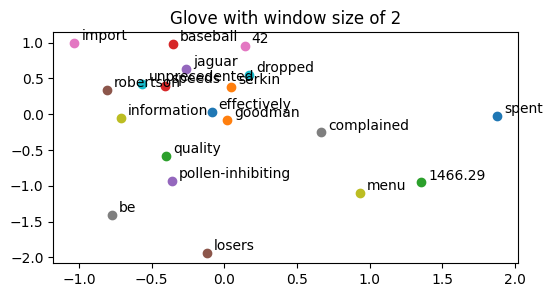

In [57]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,3))
for i, word in enumerate(vocabs[:20]): #loop each unique vocab
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.title('Glove with window size of 2')
plt.show()

In [58]:
train_set, dev_set, test_set = load_data()
print('2. Building parser....')
start = time.time()
parser = Parser(train_set)
print("took {:.2f} seconds".format(time.time()-start))

train_set = parser.numericalize(train_set)
dev_set = parser.numericalize(dev_set)
test_set = parser.numericalize(test_set)

1. Loading data
2. Building parser....
took 0.02 seconds


In [59]:
simple_model = model.load_state_dict(torch.load("GloVe_5000.pkl.pth"))

In [60]:
print("4. Loading pretrained embeddings...",)
# config = Config()
start = time.time()
# word_vectors = {}

embeddings_matrix = np.asarray(np.random.normal(0, 0.9, (parser.n_tokens, 50)), dtype='float32')

for token in parser.tok2id:
        i = parser.tok2id[token]
        if token in simple_model: #Using the nn.Embedding
            embeddings_matrix[i] = simple_model[token]
        elif token.lower() in simple_model:
            embeddings_matrix[i] = simple_model[token.lower()]
print("Embedding matrix shape (vocab, emb size): ", embeddings_matrix.shape)
print("took {:.2f} seconds".format(time.time() - start))

print("5. Preprocessing training data...",)
start = time.time()
train_examples = parser.create_instances(train_set)
print("took {:.2f} seconds".format(time.time() - start))

4. Loading pretrained embeddings...
Embedding matrix shape (vocab, emb size):  (5157, 50)
took 0.01 seconds
5. Preprocessing training data...
took 0.58 seconds


### Training

In [61]:
output_path = "./output/simple_model.weights"

print(80 * "=")
print("TRAINING")
print(80 * "=")
    
model = ParserModel(embeddings_matrix)
parser.model = model

start = time.time()
train(parser, train_examples, dev_set, output_path,
      batch_size=1024, n_epochs=10, lr=0.0005)

TRAINING
Epoch 1 out of 10


100%|██████████| 48/48 [00:01<00:00, 31.98it/s]


Average Train Loss: 0.8949284249295791
Evaluating on dev set


125250it [00:00, 17841282.93it/s]      


- dev UAS: 49.45
New best dev UAS! Saving model.

Epoch 2 out of 10


100%|██████████| 48/48 [00:01<00:00, 33.91it/s]


Average Train Loss: 0.36681096628308296
Evaluating on dev set


125250it [00:00, 20883982.35it/s]      


- dev UAS: 58.25
New best dev UAS! Saving model.

Epoch 3 out of 10


100%|██████████| 48/48 [00:01<00:00, 33.32it/s]


Average Train Loss: 0.29662349664916593
Evaluating on dev set


125250it [00:00, 20278567.74it/s]      


- dev UAS: 62.54
New best dev UAS! Saving model.

Epoch 4 out of 10


100%|██████████| 48/48 [00:01<00:00, 33.90it/s]


Average Train Loss: 0.25113755154112977
Evaluating on dev set


125250it [00:00, 20437135.81it/s]      


- dev UAS: 66.59
New best dev UAS! Saving model.

Epoch 5 out of 10


100%|██████████| 48/48 [00:01<00:00, 33.94it/s]


Average Train Loss: 0.21874841613074145
Evaluating on dev set


125250it [00:00, 20333510.45it/s]      


- dev UAS: 68.91
New best dev UAS! Saving model.

Epoch 6 out of 10


100%|██████████| 48/48 [00:01<00:00, 33.34it/s]


Average Train Loss: 0.19955227492998043
Evaluating on dev set


125250it [00:00, 20800466.27it/s]      


- dev UAS: 69.92
New best dev UAS! Saving model.

Epoch 7 out of 10


100%|██████████| 48/48 [00:01<00:00, 33.40it/s]


Average Train Loss: 0.17684676591306925
Evaluating on dev set


125250it [00:00, 19728728.26it/s]      


- dev UAS: 71.45
New best dev UAS! Saving model.

Epoch 8 out of 10


100%|██████████| 48/48 [00:01<00:00, 33.24it/s]


Average Train Loss: 0.15785764747609696
Evaluating on dev set


125250it [00:00, 20302862.84it/s]      


- dev UAS: 72.02
New best dev UAS! Saving model.

Epoch 9 out of 10


100%|██████████| 48/48 [00:01<00:00, 33.40it/s]


Average Train Loss: 0.14690264609331885
Evaluating on dev set


125250it [00:00, 19387975.20it/s]      


- dev UAS: 74.16
New best dev UAS! Saving model.

Epoch 10 out of 10


100%|██████████| 48/48 [00:01<00:00, 33.53it/s]


Average Train Loss: 0.134395830022792
Evaluating on dev set


125250it [00:00, 19691014.51it/s]      

- dev UAS: 72.69



In [62]:
print(80 * "=")
print("TESTING")
print(80 * "=")

print("Restoring the best model weights found on the dev set")
parser.model.load_state_dict(torch.load(output_path))
print("Final evaluation on test set",)
parser.model.eval()
UAS, dependencies = parser.parse(test_set)
print("- test UAS: {:.2f}".format(UAS * 100.0))
print("Done!")

TESTING
Restoring the best model weights found on the dev set
Final evaluation on test set


125250it [00:00, 20720884.16it/s]      

- test UAS: 74.61
Done!


### Glove embedding (smallest)

In [72]:
from gensim.test.utils import datapath
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

glove_file = datapath('G:/Other computers/My Laptop/Thailand/2nd Semester/NLP - Natural Language Processing/CODING/SIRI_code_along/Data/glove.6B/glove.6B.50d.txt')
model_gensim = KeyedVectors.load_word2vec_format(glove_file, binary=False, no_header=True)

In [66]:
import gensim
gensim.__version__

'4.3.0'

In [67]:
train_set, dev_set, test_set = load_data()
# len(train_set), len(dev_set), len(test_set)
print('2. Building parser....')
start = time.time()
parser = Parser(train_set)
print("took {:.2f} seconds".format(time.time()-start))

train_set = parser.numericalize(train_set)
dev_set = parser.numericalize(dev_set)
test_set = parser.numericalize(test_set)

1. Loading data
2. Building parser....
took 0.01 seconds


In [68]:
print("4. Loading pretrained embeddings...",)
# config = Config()
start = time.time()
# word_vectors = {}

embeddings_matrix = np.asarray(np.random.normal(0, 0.9, (parser.n_tokens, 50)), dtype='float32')

for token in parser.tok2id:
        i = parser.tok2id[token]
        if token in model_gensim: #Changeing word_vector from en-cw.txt to glove.6B.50d.txt instead
            embeddings_matrix[i] = model_gensim[token]
        elif token.lower() in model_gensim:
            embeddings_matrix[i] = model_gensim[token.lower()]
print("Embedding matrix shape (vocab, emb size): ", embeddings_matrix.shape)
print("took {:.2f} seconds".format(time.time() - start))

print("5. Preprocessing training data...",)
start = time.time()
train_examples = parser.create_instances(train_set)
print("took {:.2f} seconds".format(time.time() - start))

4. Loading pretrained embeddings...
Embedding matrix shape (vocab, emb size):  (5157, 50)
took 0.01 seconds
5. Preprocessing training data...
took 0.64 seconds


In [69]:
#create directory if it does not exist for saving the weights...
output_path = "./output/gensim_model.weights"

print(80 * "=")
print("TRAINING")
print(80 * "=")
    
model = ParserModel(embeddings_matrix)
parser.model = model

start = time.time()
train(parser, train_examples, dev_set, output_path,
      batch_size=1024, n_epochs=10, lr=0.0005)

TRAINING
Epoch 1 out of 10


100%|██████████| 48/48 [00:01<00:00, 33.99it/s]


Average Train Loss: 0.9707792457193136
Evaluating on dev set


125250it [00:00, 21302322.53it/s]      


- dev UAS: 46.97
New best dev UAS! Saving model.

Epoch 2 out of 10


100%|██████████| 48/48 [00:01<00:00, 34.45it/s]


Average Train Loss: 0.39759898744523525
Evaluating on dev set


125250it [00:00, 24805769.01it/s]      


- dev UAS: 57.75
New best dev UAS! Saving model.

Epoch 3 out of 10


100%|██████████| 48/48 [00:01<00:00, 34.38it/s]


Average Train Loss: 0.31788192441066104
Evaluating on dev set


125250it [00:00, 23198788.96it/s]      


- dev UAS: 62.03
New best dev UAS! Saving model.

Epoch 4 out of 10


100%|██████████| 48/48 [00:01<00:00, 34.63it/s]


Average Train Loss: 0.2770400792360306
Evaluating on dev set


125250it [00:00, 20989954.29it/s]      


- dev UAS: 64.45
New best dev UAS! Saving model.

Epoch 5 out of 10


100%|██████████| 48/48 [00:01<00:00, 34.57it/s]


Average Train Loss: 0.24812005273997784
Evaluating on dev set


125250it [00:00, 25055400.20it/s]      


- dev UAS: 68.21
New best dev UAS! Saving model.

Epoch 6 out of 10


100%|██████████| 48/48 [00:01<00:00, 34.23it/s]


Average Train Loss: 0.22367100045084953
Evaluating on dev set


125250it [00:00, 20979895.21it/s]      


- dev UAS: 68.27
New best dev UAS! Saving model.

Epoch 7 out of 10


100%|██████████| 48/48 [00:01<00:00, 34.45it/s]


Average Train Loss: 0.2012074220304688
Evaluating on dev set


125250it [00:00, 20410139.32it/s]      


- dev UAS: 70.80
New best dev UAS! Saving model.

Epoch 8 out of 10


100%|██████████| 48/48 [00:01<00:00, 34.33it/s]


Average Train Loss: 0.18241788819432259
Evaluating on dev set


125250it [00:00, 24008801.06it/s]      


- dev UAS: 70.47

Epoch 9 out of 10


100%|██████████| 48/48 [00:01<00:00, 34.18it/s]


Average Train Loss: 0.17252893714855114
Evaluating on dev set


125250it [00:00, 18963850.12it/s]      


- dev UAS: 73.52
New best dev UAS! Saving model.

Epoch 10 out of 10


100%|██████████| 48/48 [00:01<00:00, 33.24it/s]


Average Train Loss: 0.15723968390375376
Evaluating on dev set


125250it [00:00, 20621651.66it/s]      

- dev UAS: 74.22
New best dev UAS! Saving model.



In [70]:
print(80 * "=")
print("TESTING")
print(80 * "=")

print("Restoring the best model weights found on the dev set")
parser.model.load_state_dict(torch.load(output_path))
print("Final evaluation on test set",)
parser.model.eval()
UAS, dependencies = parser.parse(test_set)
print("- test UAS: {:.2f}".format(UAS * 100.0))
print("Done!")

TESTING
Restoring the best model weights found on the dev set
Final evaluation on test set


125250it [00:00, 20865733.65it/s]      

- test UAS: 75.67
Done!


### nn.Embedding from scratch